# Восстановление золота из руды

Компания «Цифра» разрабатывает решения для эффективной работы промышленных предприятий. Для оптимизации производства было принято решение построить модель машинного обучения, способную предсказать коэффициент восстановления золота из золотосодержащей руды. 

В нашем распоряжении данные с параметрами добычи и очистки. Обучим на них разные модели и выберем одну с минимальным значением метрики sMAPE.

**Цель исследования**: подготовить прототип модели машинного обучения, способную предсказать коэффициент восстановления золота из золотосодержащей руды.

**Ход исследования**

Данные для исследования получим из файлов `gold_recovery_train_new.csv`, `gold_recovery_test_new.csv`, `gold_recovery_full_new.csv`. О качестве данных ничего не известно, поэтому перед обучением моделей понадобится их проверить. Найдем ошибки данных и оценим их влияние на исследование. На этапе подготовки попробуем исправить критичные из них.

Исследование пройдет в три этапа:
1. Подготовка данных;
2. Исследовательский анализ данных;
3. Построение и обучение модели.

## Подготовка данных

Для начала импортируем необходимые в работе библиотеки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

Прочитаем файлы `gold_recovery_train_new.csv`, `gold_recovery_test_new.csv`, `gold_recovery_full_new.csv` из каталога `datasets` и сохраним их в одноименных переменных. В качестве индекса будем использовать столбец с датами.

In [2]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col=0)
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col=0)
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col=0)

Составим первое впечатление о данных:
1. Получим общую информацию методом `info()`.
2. Выведем на экран первые пять строк таблицы методом `head()`. 
3. Оценим разброс значений методом `describe()`.

In [3]:
for data in (gold_recovery_train, gold_recovery_test, gold_recovery_full):
    data.info()
    display(data.head())
    display(data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                             

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


Итак, перед нами три таблицы: 
* gold_recovery_full - таблица с исходными данными, состоящая из 86 столбцов;
* gold_recovery_train - обучающая выборка исходных данных, также состоящая из 86 столбцов;
* gold_recovery_test - тестовая выборка исходных данных, состоящая из 52 столбцов.

Согласно пояснению к данным: тестовая выборка не содержит целевых признаков, из-за чего ее размер меньше двух других таблиц. 

Проверим, что эффективность обогащения рассчитана правильно. Для этого напишем функцию `get_recovery()`, рассчитаем эффективность на исходных данных и сравним полученные значения со значениями признака `rougher.output.recovery`.

In [4]:
def get_recovery(data):
    C = data['rougher.output.concentrate_au']
    F = data['rougher.input.feed_au']
    T = data['rougher.output.tail_au']
    try:
        recovery = (C * (F - T)/ (F * (C - T))) * 100 
    except:
        recovery = 0
    return recovery

Вызовем для каждой строки исходных данных функцию расчета эффективности обогащения, сохраним полученные значения в объекте `recovery_estimated`.

In [5]:
recovery_estimated = pd.Series(dtype='float32')
recovery_estimated = gold_recovery_full.apply(get_recovery, axis=1)

Рассчитаем среднюю абсолютную ошибку MAE с помощью функции `mean_absolute_error()` библиотеки sklearn.

In [6]:
mean_absolute_error(gold_recovery_full['rougher.output.recovery'], recovery_estimated)

9.874045668302637e-15

Значение метрики MAE близко к нулю, что говорит о ничтожно малых различиях между корректными и рассчитанными по формуле значениями. Таким образом, эффективность обогащения рассчитана верно.

Рассмотрим, какие из признаков исходных данных отсутствуют в тестовой выборке.

In [7]:
gold_recovery_train.columns.difference(gold_recovery_test.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

В тестовых данных отсутствуют признаки с типом параметра output (параметры продукта) и calculation (расчётные характеристики). Отсюда можно сделать вывод, что такие признаки невозможно измерить во время выполнения технологического процесса.

Удалим отсутствующие признаки из обучающей выборки.

In [8]:
gold_recovery_train = gold_recovery_train[gold_recovery_test.columns]

В таблицах имеются пропущенные значения некоторых признаков. Согласно пояснению к данным: соседние по времени параметры часто похожи. Заполним пропущенные значения методом `fillna()`, указав в параметре `method` значение bfill.

In [9]:
gold_recovery_train = gold_recovery_train.fillna(method='bfill')
gold_recovery_test = gold_recovery_test.fillna(method='bfill')

### Выводы

На этапе предобработки были устранены пропуски в данных, проверена корректность расчета эффективности обогащения и проанализированы признаки обучающей выборки, недоступные в тестовой.

После подготовки данных можно переходить к их анализу.

## Анализ данных

Изучим, как меняется концентрация сырья на разных этапах очистки. Отобразим распределение концентрата серебра, свинца и золота в смеси руды на графиках boxplot.

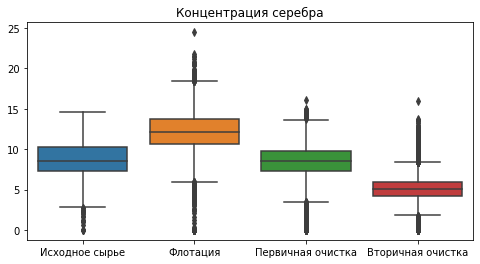

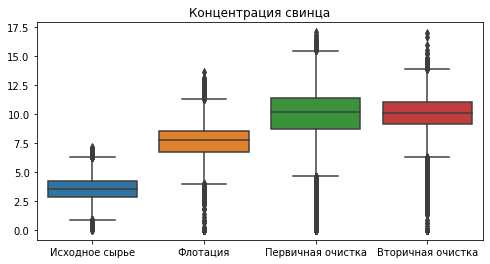

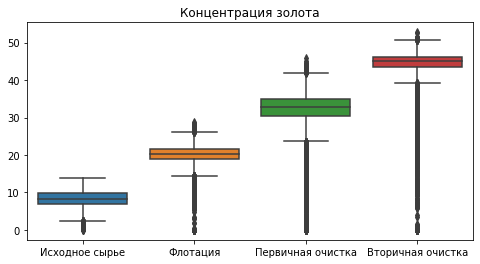

In [10]:
concentrate_ag = gold_recovery_full[['rougher.input.feed_ag',
                                      'rougher.output.concentrate_ag', 
                                      'primary_cleaner.output.concentrate_ag', 
                                      'final.output.concentrate_ag']]
concentrate_ag.name = 'Концентрация серебра'

concentrate_pb = gold_recovery_full[['rougher.input.feed_pb',
                                      'rougher.output.concentrate_pb', 
                                      'primary_cleaner.output.concentrate_pb', 
                                      'final.output.concentrate_pb']]
concentrate_pb.name = 'Концентрация свинца'

concentrate_au = gold_recovery_full[['rougher.input.feed_au',
                                      'rougher.output.concentrate_au', 
                                      'primary_cleaner.output.concentrate_au', 
                                      'final.output.concentrate_au']]
concentrate_au.name = 'Концентрация золота'

concentrate_me = [concentrate_ag, concentrate_pb, concentrate_au]
for me in concentrate_me:
    me.columns = ['Исходное сырье', 'Флотация', 'Первичная очистка', 'Вторичная очистка']

for me in concentrate_me:
    fig, ax = plt.subplots()
    ax = sns.boxplot(data=me)
    ax.set_title(me.name)
    fig.set_figwidth(8)

По графику размаха заметно, что концентрация серебра в смеси руды повышается после флотации, а затем с каждым этапом очистки снижается, в то время как концетрация золота растет на протяжении всего процесса очистки. Повышение концентрации свинца наблюдается после первичной очистки, почти такая же концентрацию имеем и на выходе, что говорит о незначительном изменении содержания металла в смеси после вторичной очистки.

Сравним распределение размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

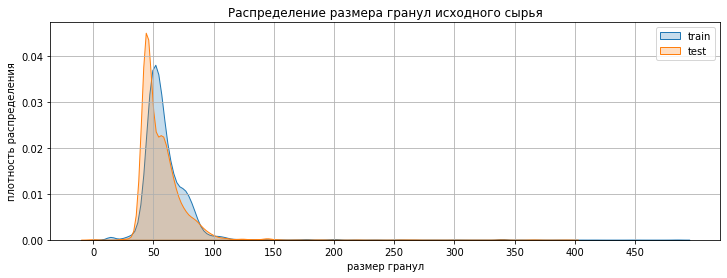

count    14149.000000
mean        59.955950
std         23.286534
min          9.659576
25%         48.920770
50%         55.301596
75%         65.941463
max        484.967466
Name: rougher.input.feed_size, dtype: float64

count    5290.000000
mean       55.952917
std        19.080412
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

In [11]:
fig, ax = plt.subplots()
ax = sns.kdeplot(gold_recovery_train['rougher.input.feed_size'], shade=True)
sns.kdeplot(gold_recovery_test['rougher.input.feed_size'], shade=True)
ax.set_title('Распределение размера гранул исходного сырья')
ax.set_xlabel('размер гранул')
ax.set_ylabel('плотность распределения')
ax.legend(['train', 'test'])
ax.grid()
fig.set_figwidth(12)
plt.xticks(range(0, 500, 50))
plt.show()

display(gold_recovery_train['rougher.input.feed_size'].describe())
display(gold_recovery_test['rougher.input.feed_size'].describe())

Теперь изучим распределение размера гранул сырья после флотации для обучающей и тестовой выборок.

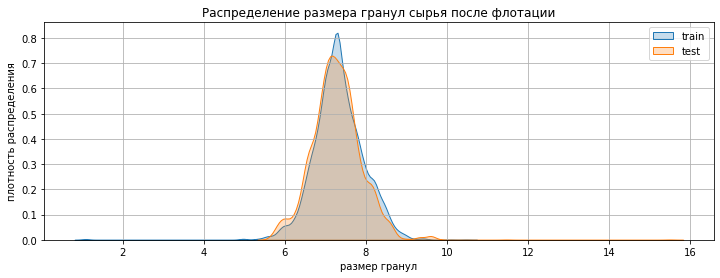

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

count    5290.000000
mean        7.266339
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

In [12]:
fig, ax = plt.subplots()
ax = sns.kdeplot(gold_recovery_train['primary_cleaner.input.feed_size'], shade=True)
sns.kdeplot(gold_recovery_test['primary_cleaner.input.feed_size'], shade=True)
ax.set_title('Распределение размера гранул сырья после флотации')
ax.set_xlabel('размер гранул')
ax.set_ylabel('плотность распределения')
ax.legend(['train', 'test'])
ax.grid()
fig.set_figwidth(12)
plt.show()

display(gold_recovery_train['primary_cleaner.input.feed_size'].describe())
display(gold_recovery_test['primary_cleaner.input.feed_size'].describe())

В целом, распределение значений размера гранул сырья на обоих этапах для обучающей и тестовой выборок схоже. В таком случае оценка модели обучения будет корректной.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [13]:
concentrate = pd.DataFrame()
concentrate['feed'] = gold_recovery_full[['rougher.input.feed_ag', 
                                        'rougher.input.feed_pb', 
                                        'rougher.input.feed_sol',
                                        'rougher.input.feed_au']].sum(axis=1)

concentrate['rougher'] = gold_recovery_full[['rougher.output.concentrate_ag', 
                                           'rougher.output.concentrate_pb', 
                                           'rougher.output.concentrate_sol',
                                           'rougher.output.concentrate_au']].sum(axis=1)

concentrate['final'] = gold_recovery_full[['final.output.concentrate_ag', 
                                         'final.output.concentrate_pb', 
                                         'final.output.concentrate_sol',
                                         'final.output.concentrate_au']].sum(axis=1)

Визуализируем полученные значения суммарных концентраций веществ с помощью гистограммы.

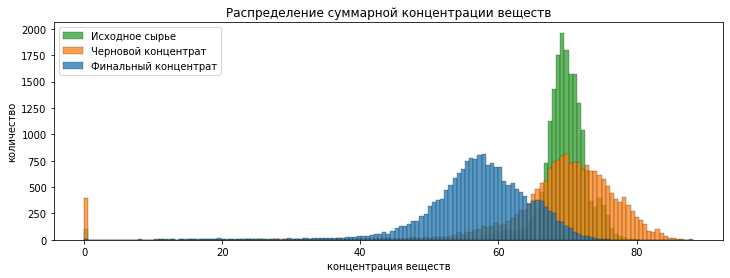

In [14]:
fig, ax = plt.subplots()
ax = sns.histplot(data = concentrate)
ax.set_title('Распределение суммарной концентрации веществ')
ax.set_xlabel('концентрация веществ')
ax.set_ylabel('количество')
ax.legend(['Исходное сырье', 'Черновой концентрат', 'Финальный концентрат'])
fig.set_figwidth(12)

По диаграмме видно, что в данных встречаются строки, суммарная концентрация веществ в черновом и финальном концентратах для которых равна нулю. Вероятно сведения не были зафиксированы в ходе технологического процесса из-за технического сбоя или по причине человеческой фактора. 

Такие аномальные значения не являются корректными и могут повлиять на качество модели обучения, избавимся от них в обучающей и тестовой выборках.

In [15]:
concentrate = concentrate.loc[(concentrate['feed'] > 0) & 
                              (concentrate['rougher'] > 0) & 
                              (concentrate['final'] > 0)]

gold_recovery_train = gold_recovery_train.query('@gold_recovery_train.index in @concentrate.index')
gold_recovery_test = gold_recovery_test.query('@gold_recovery_test.index in @concentrate.index')

### Выводы

Изучив данные, мы смогли увидеть закономерность в изменении концентрации металлов на каждом этапе очистки. Так концентрация серебра в смеси руды повышается после флотации, а затем с каждым этапом очистки снижается. Концетрация золота растет на протяжении всего процесса очистки. Концентрация свинца также повышается, однако после вторичной очистки содержание металла в смеси почти неизменно.

Исследовав суммарные концентрации веществ, мы обнаружили нулевые значения концентраций и исключили их из наших выборок.

Распределение размера гранул сырья в обучающей и тестовой выборках схоже между собой. Небольшие различия не должны повлиять на качество обучения модели.

## Построение и обучение модели

Напишем функцию для вычисления метрики sMAPE: к минимизации ее значения будем стремиться при обучении моделей.

In [16]:
def get_total_smape(target, predicted):
    a = np.array(target['rougher.output.recovery'])
    b = np.array(predicted[:, 0])
    c = np.array(target['final.output.recovery'])
    d = np.array(predicted[:, 1])
    rougher_smape = 1 / len(target) * np.sum(np.abs(a - b) / ((np.abs(a) + np.abs(b)) / 2)) * 100
    final_smape = 1 / len(target) * np.sum(np.abs(c - d) / ((np.abs(c) + np.abs(d)) / 2)) * 100
    return 0.25 * rougher_smape + 0.75 * final_smape

Целевыми признаками наших таблиц являются `rougher.output.recovery` и `final.output.recovery`: выделим их из общей таблицы и запишем в переменные target.

In [17]:
target_train = pd.DataFrame(gold_recovery_full[['rougher.output.recovery', 'final.output.recovery']], 
                            index=gold_recovery_train.index)

target_test = pd.DataFrame(gold_recovery_full[['rougher.output.recovery', 'final.output.recovery']],
                           index=gold_recovery_test.index)

Чтобы избавиться от разброса значений количественных признаков в таблицах `gold_recovery_train` и `gold_recovery_test`, нормализуем их с помощью функции `StandardScaler()` библиотеки `sklearn`.

In [18]:
scaler = StandardScaler()
scaler.fit(gold_recovery_train)
gold_recovery_train = scaler.transform(gold_recovery_train)
gold_recovery_test = scaler.transform(gold_recovery_test)

Для решения задачи регрессии будем использовать три модели:
* дерево решений;
* случайный лес;
* линейная регрессия.

Воспользуемся функцией `make_scorer()`, чтобы в качестве метрики при кросс-валидации использовать собственную sMAPE.

In [19]:
smape = make_scorer(get_total_smape, greater_is_better=False)

Определим лучшее дерево решений, изменяя значения гиперпараметра `max_depth` (максимальная глубина дерева).

In [20]:
for depth in range(10, 51, 10):
    model = DecisionTreeRegressor(random_state=777, max_depth=depth)
    scores = cross_val_score(model, gold_recovery_train, target_train, scoring=smape, cv=3)
    final_score = abs(sum(scores)/len(scores))
    print(f'Средняя оценка качества модели {model}: {final_score}')

Средняя оценка качества модели DecisionTreeRegressor(max_depth=10, random_state=777): 17.194806339102794
Средняя оценка качества модели DecisionTreeRegressor(max_depth=20, random_state=777): 15.961051276575018
Средняя оценка качества модели DecisionTreeRegressor(max_depth=30, random_state=777): 15.993625859904796
Средняя оценка качества модели DecisionTreeRegressor(max_depth=40, random_state=777): 17.453173863263444
Средняя оценка качества модели DecisionTreeRegressor(max_depth=50, random_state=777): 17.453173863263444


Лучшим деревом решений с `sMAPE` = 15.96 является дерево со значением гиперпараметра `max_depth` = 20.

Найдем лучшие гиперпараметры для модели случайный лес.

In [21]:
for n_estimators in [10, 50, 100]:
    for depth in range(10, 51, 10):
        model = RandomForestRegressor(random_state=777, max_depth=depth,
                                      n_estimators = n_estimators)
        scores = cross_val_score(model, gold_recovery_train, 
                                 target_train, scoring=smape, cv=3)
        final_score = abs(sum(scores)/len(scores))
        print(f'Средняя оценка качества модели {model}: {final_score}')

Средняя оценка качества модели RandomForestRegressor(max_depth=10, n_estimators=10, random_state=777): 10.652975838989825
Средняя оценка качества модели RandomForestRegressor(max_depth=20, n_estimators=10, random_state=777): 11.032509274903044
Средняя оценка качества модели RandomForestRegressor(max_depth=30, n_estimators=10, random_state=777): 10.899340700292727
Средняя оценка качества модели RandomForestRegressor(max_depth=40, n_estimators=10, random_state=777): 10.790899589443805
Средняя оценка качества модели RandomForestRegressor(max_depth=50, n_estimators=10, random_state=777): 10.809616159885339
Средняя оценка качества модели RandomForestRegressor(max_depth=10, n_estimators=50, random_state=777): 10.3262901895109
Средняя оценка качества модели RandomForestRegressor(max_depth=20, n_estimators=50, random_state=777): 10.455492084968073
Средняя оценка качества модели RandomForestRegressor(max_depth=30, n_estimators=50, random_state=777): 10.492306830167962
Средняя оценка качества мо

Случайный лес с гиперпараметрами `max_depth` = 10 и `n_estimators` = 100 смог добиться лучшего `sMAPE` = 10.21.

Перейдем к обучению модели линейной регрессии.

In [22]:
model = LinearRegression()
model.fit(gold_recovery_train, target_train)
print(f'sMAPE на обучающей выборке: {get_total_smape(target_train, model.predict(gold_recovery_train))}')

sMAPE на обучающей выборке: 7.249286189897486


Лучшее значение метрики `sMAPE` = 7.25 показала модель линейной регрессии. Проверим ее качество на тестовой выборке.

In [23]:
model = LinearRegression()
model.fit(gold_recovery_train, target_train)
print(f'sMAPE на обучающей выборке: {get_total_smape(target_test, model.predict(gold_recovery_test))}')

sMAPE на обучающей выборке: 7.697982081429091


### Выводы

В качестве моделей обучения были выбраны дерево решений, случайный лес и линейная регрессия. Изменяя значения гиперпараметров и применив кросс-валидацию, мы смогли достичь на обучающей выборке лучшего значения sMAPE-меры. Лучшее качество показала модель линейной регрессии: sMAPE = 7.25 на обучающей и 7.7 на тестовой выборке.

## Общий вывод

В ходе исследования были изучены данные с параметрами добычи и очистки золотосодержащей руды. После предобработки и проверки данных на корректность было проведено обучение трех моделей: дерево решений, случайный лес и линейная регрессия для прогнозирования коэффициента восстановления золота в черновом и финальном концентратах. Для каждой модели были определены гиперпараметры, позволяющие добиться лучшего значения sMAPE-метрики. Для повышения качества модели была использована кросс-валидация.

Наилучшее качество показала модель линейной регрессии. На обучающей выборке модель обучения смогла достигнуть значения sMAPE, равное 7.25. Значение sMAPE на тестовой выборке: 7.7. Таким образом, выбирая модель машинного обучения для решения задачи исследования, особое внимание следует обратить на модель линейной регрессии. 